In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder,OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    roc_curve,
    auc,
    roc_auc_score,
    accuracy_score,
    make_scorer
)
import os
from ucimlrepo import fetch_ucirepo 
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import cross_val_score
import toad
from sklearn.model_selection import GridSearchCV
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

from imblearn.pipeline import Pipeline as ImbPipeline 
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import PCA



In [68]:
df = pd.read_csv('german.data', header=None, sep=' ')

  
# metadata 
#print(statlog_german_credit_data.metadata) 
  
# variable information 
#statlog_german_credit_data.variables

Based on the german.doc we can mapping the columns name like this

In [69]:
col_names = ['status_account', 'duration_months', 'credit_history', 'purpose',
             'credit_amount', 'savings_account', 'present_employment',
             'installment_rate', 'personal_status_sex', 'other_debtors',
             'present_residence', 'property', 'age_years', 'other_installment_plans',
             'housing', 'num_existing_credits', 'job', 'num_dependents', 'telephone',
             'foreign_worker', 'credit_risk'] 

In [70]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


In [71]:
#Rename columns
df.columns = col_names

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   status_account           1000 non-null   object
 1   duration_months          1000 non-null   int64 
 2   credit_history           1000 non-null   object
 3   purpose                  1000 non-null   object
 4   credit_amount            1000 non-null   int64 
 5   savings_account          1000 non-null   object
 6   present_employment       1000 non-null   object
 7   installment_rate         1000 non-null   int64 
 8   personal_status_sex      1000 non-null   object
 9   other_debtors            1000 non-null   object
 10  present_residence        1000 non-null   int64 
 11  property                 1000 non-null   object
 12  age_years                1000 non-null   int64 
 13  other_installment_plans  1000 non-null   object
 14  housing                  1000 non-null   

In [73]:
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
numerical_features = df.select_dtypes(include=['int64']).columns.tolist()

In [74]:
#Check for missing values
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

Series([], dtype: int64)


No missing values

In [75]:
TARGET_VAR = 'credit_risk'

In [76]:
print(df[TARGET_VAR].value_counts())

1    700
2    300
Name: credit_risk, dtype: int64


In [77]:
# Map target variable (Bad=1, Good=0)
df[TARGET_VAR] = df[TARGET_VAR].map({1: 0, 2: 1})
print("Target variable mapped (0=Good, 1=Bad):")
print(df[TARGET_VAR].value_counts())

Target variable mapped (0=Good, 1=Bad):
0    700
1    300
Name: credit_risk, dtype: int64


### Mapping categorical

In [78]:
df_eda = df.copy()

In [79]:
status_account_map = {
    'A11': '< 0 DM',
    'A12': '0 <= ... < 200 DM',
    'A13': '>= 200 DM',
    'A14': 'no checking account'
}

credit_history_map = {
    'A30': 'no credits/all paid',
    'A31': 'all paid duly',
    'A32': 'existing credits paid duly till now',
    'A33': 'delay in paying off',
    'A34': 'critical account/other credits'
}

purpose_map = {
    'A40': 'car (new)',
    'A41': 'car (used)',
    'A42': 'furniture/equipment',
    'A43': 'radio/television',
    'A44': 'domestic appliances',
    'A45': 'repairs',
    'A46': 'education',
    'A48': 'retraining',
    'A49': 'business',
    'A410': 'others'
}

savings_account_map = {
    'A61': '< 100 DM',
    'A62': '100 <= ... < 500 DM',
    'A63': '500 <= ... < 1000 DM',
    'A64': '>= 1000 DM',
    'A65': 'no savings account'
}

present_employment_map = {
    'A71': 'unemployed',
    'A72': '< 1 year',
    'A73': '1 <= ... < 4 years',
    'A74': '4 <= ... < 7 years',
    'A75': '>= 7 years'
}

personal_status_sex_map = {
    'A91': 'male: divorced/separated',
    'A92': 'female: divorced/separated/married',
    'A93': 'male: single',
    'A94': 'male: married/widowed',
    'A95': 'female: single'
}

other_debtors_map = {
    'A101': 'none',
    'A102': 'co-applicant',
    'A103': 'guarantor'
}

property_map = {
    'A121': 'real estate',
    'A122': 'building society savings/life insurance',
    'A123': 'car or other',
    'A124': 'no property'
}

other_installment_plans_map = {
    'A141': 'bank',
    'A142': 'stores',
    'A143': 'none'
}

housing_map = {
    'A151': 'rent',
    'A152': 'own',
    'A153': 'for free'
}

job_map = {
    'A171': 'unemployed/unskilled-non-resident',
    'A172': 'unskilled-resident',
    'A173': 'skilled employee/official',
    'A174': 'management/self-employed/highly qualified'
}

telephone_map = {
    'A191': 'none',
    'A192': 'yes' 
}

foreign_worker_map = {
    'A201': 'yes',
    'A202': 'no'
}


In [80]:
master_map = {
    'status_account': status_account_map,
    'credit_history': credit_history_map,
    'purpose': purpose_map,
    'savings_account': savings_account_map,
    'present_employment': present_employment_map,
    'personal_status_sex': personal_status_sex_map,
    'other_debtors': other_debtors_map,
    'property': property_map,
    'other_installment_plans': other_installment_plans_map,
    'housing': housing_map,
    'job': job_map,
    'telephone': telephone_map,
    'foreign_worker': foreign_worker_map
}

# Apply the mapping to each categorical column
for col in categorical_features:
    if col in master_map:
        df_eda[col] = df_eda[col].map(master_map[col])
    else:
        print(f"No map found for column: {col}")

In [81]:
for col in categorical_features:
    df_eda[col] = df_eda[col].astype('category')
print(df_eda.dtypes)
df_eda.head()

status_account             category
duration_months               int64
credit_history             category
purpose                    category
credit_amount                 int64
savings_account            category
present_employment         category
installment_rate              int64
personal_status_sex        category
other_debtors              category
present_residence             int64
property                   category
age_years                     int64
other_installment_plans    category
housing                    category
num_existing_credits          int64
job                        category
num_dependents                int64
telephone                  category
foreign_worker             category
credit_risk                   int64
dtype: object


,status_account,duration_months,credit_history,purpose,credit_amount,savings_account,present_employment,installment_rate,personal_status_sex,other_debtors,...,property,age_years,other_installment_plans,housing,num_existing_credits,job,num_dependents,telephone,foreign_worker,credit_risk
0,< 0 DM,6,critical account/other credits,radio/television,1169,no savings account,>= 7 years,4,male: single,none,...,real estate,67,none,own,2,skilled employee/official,1,yes,yes,0
1,0 <= ... < 200 DM,48,existing credits paid duly till now,radio/television,5951,< 100 DM,1 <= ... < 4 years,2,female: divorced/separated/married,none,...,real estate,22,none,own,1,skilled employee/official,1,none,yes,1
2,no checking account,12,critical account/other credits,education,2096,< 100 DM,4 <= ... < 7 years,2,male: single,none,...,real estate,49,none,own,1,unskilled-resident,2,none,yes,0
3,< 0 DM,42,existing credits paid duly till now,furniture/equipment,7882,< 100 DM,4 <= ... < 7 years,2,male: single,guarantor,...,building society savings/life insurance,45,none,for free,1,skilled employee/official,2,none,yes,0
4,< 0 DM,24,delay in paying off,car (new),4870,< 100 DM,1 <= ... < 4 years,3,male: single,none,...,no property,53,none,for free,2,skilled employee/official,2,none,yes,1


In [82]:
print("\n--- Descriptive Statistics (Numerical Features) ---")
print(df_eda[numerical_features].describe())


--- Descriptive Statistics (Numerical Features) ---
       duration_months  credit_amount  installment_rate  present_residence  \
count      1000.000000    1000.000000       1000.000000        1000.000000   
mean         20.903000    3271.258000          2.973000           2.845000   
std          12.058814    2822.736876          1.118715           1.103718   
min           4.000000     250.000000          1.000000           1.000000   
25%          12.000000    1365.500000          2.000000           2.000000   
50%          18.000000    2319.500000          3.000000           3.000000   
75%          24.000000    3972.250000          4.000000           4.000000   
max          72.000000   18424.000000          4.000000           4.000000   

         age_years  num_existing_credits  num_dependents  credit_risk  
count  1000.000000           1000.000000     1000.000000  1000.000000  
mean     35.546000              1.407000        1.155000     0.300000  
std      11.375469          

### Visualization

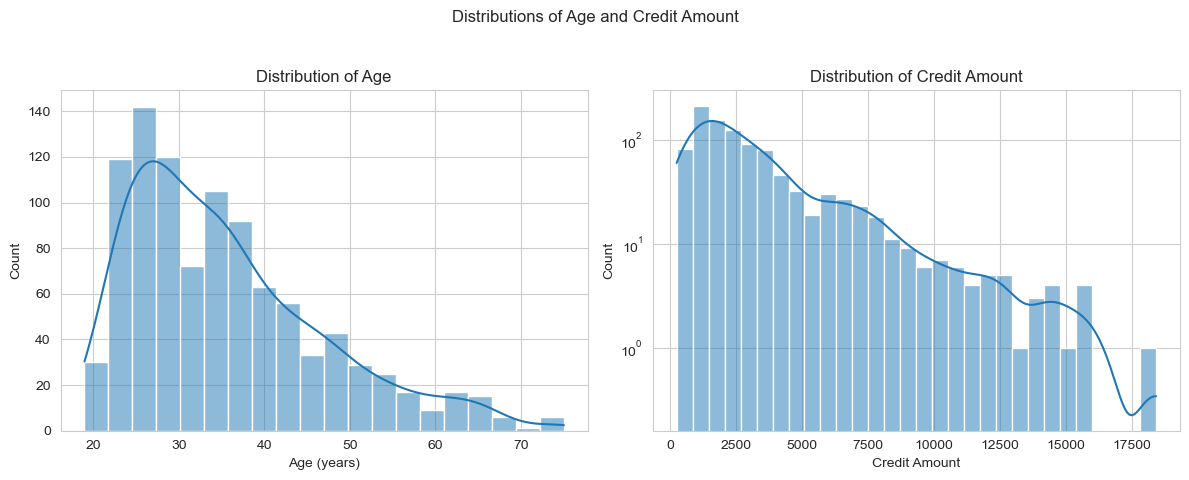

In [83]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df_eda['age_years'], kde=True, bins=20)
plt.title('Distribution of Age')
plt.xlabel('Age (years)')

plt.subplot(1, 2, 2)
sns.histplot(df_eda['credit_amount'], kde=True, bins=30)
plt.title('Distribution of Credit Amount')
plt.xlabel('Credit Amount')
plt.yscale('log') 

plt.suptitle('Distributions of Age and Credit Amount')
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.show()

- Unimodal distribution, with most individuals falling within a specific age range (20-50) -> if any outliers in this will removed
- Bins age group
- Credit amount: right-skewed distribution -> log transformation to reduced skewness -> bins for credit amout (high,med,low)

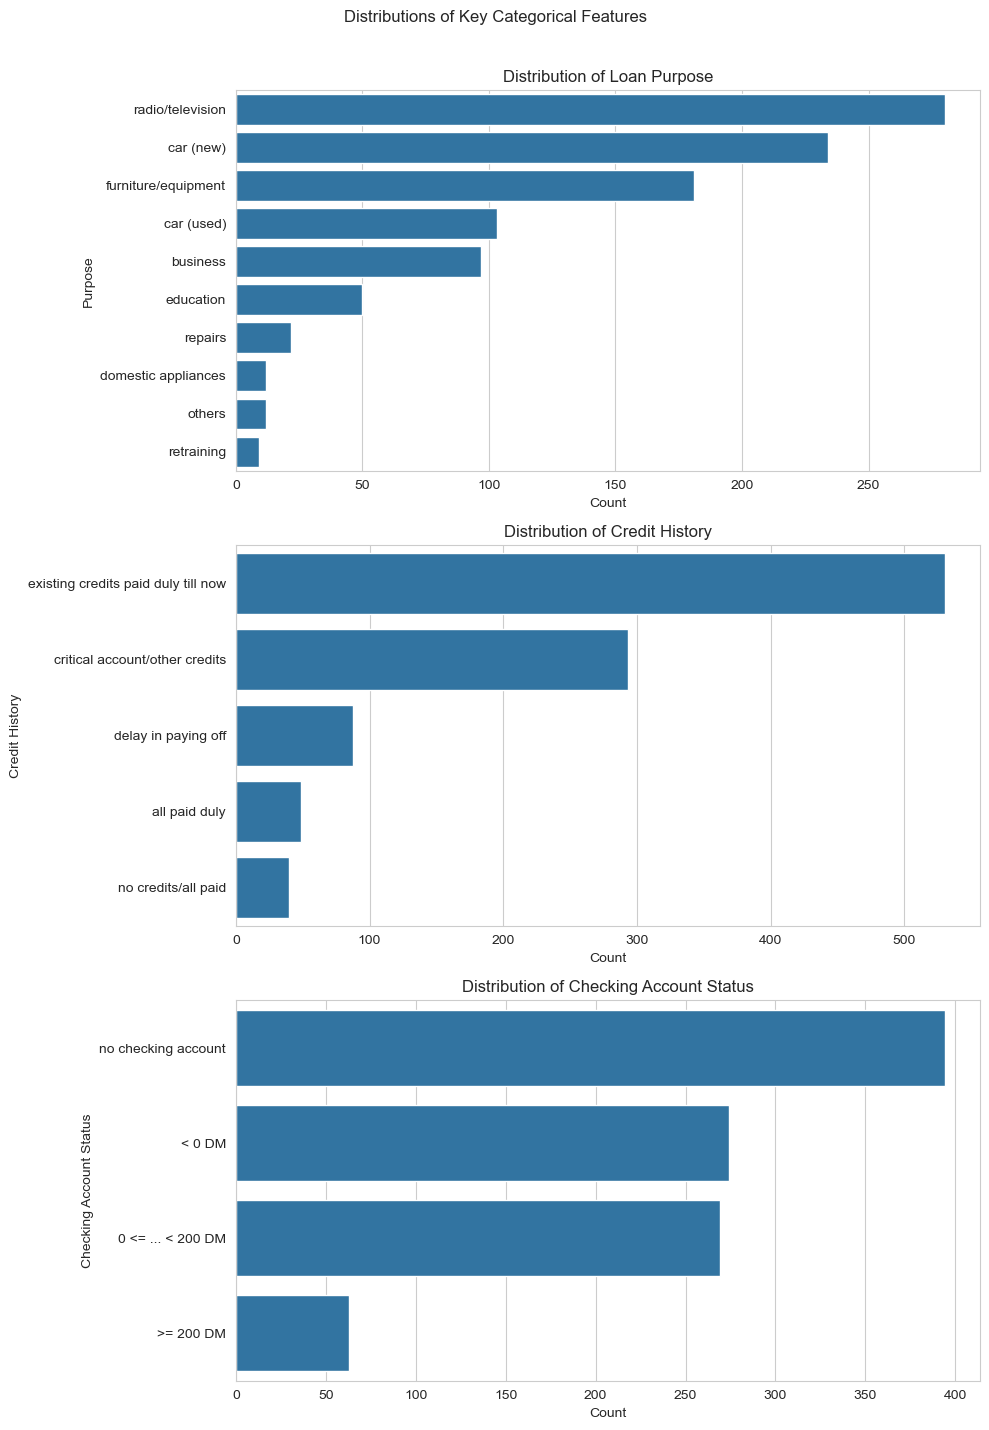

In [84]:
plt.figure(figsize=(10, 15))

plt.subplot(3, 1, 1)
sns.countplot(y='purpose', data=df_eda, order = df_eda['purpose'].value_counts().index)
plt.title('Distribution of Loan Purpose')
plt.xlabel('Count')
plt.ylabel('Purpose')

plt.subplot(3, 1, 2)
sns.countplot(y='credit_history', data=df_eda, order = df_eda['credit_history'].value_counts().index)
plt.title('Distribution of Credit History')
plt.xlabel('Count')
plt.ylabel('Credit History')

plt.subplot(3, 1, 3)
sns.countplot(y='status_account', data=df_eda, order = df_eda['status_account'].value_counts().index)
plt.title('Distribution of Checking Account Status')
plt.xlabel('Count')
plt.ylabel('Checking Account Status')

plt.suptitle('Distributions of Key Categorical Features')
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

one-hot encoding this

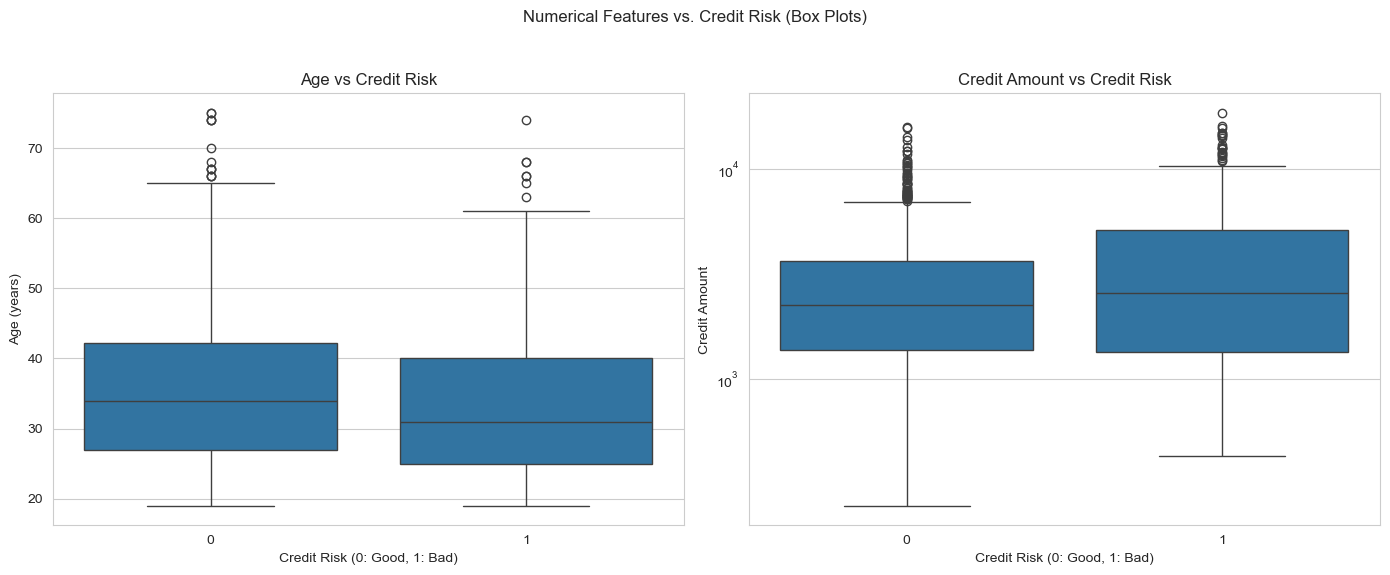

In [85]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='credit_risk', y='age_years', data=df_eda)
plt.title('Age vs Credit Risk')
plt.xlabel('Credit Risk (0: Good, 1: Bad)')
plt.ylabel('Age (years)')

plt.subplot(1, 2, 2)
sns.boxplot(x='credit_risk', y='credit_amount', data=df_eda)
plt.title('Credit Amount vs Credit Risk')
plt.xlabel('Credit Risk (0: Good, 1: Bad)')
plt.ylabel('Credit Amount')
plt.yscale('log')

plt.suptitle('Numerical Features vs. Credit Risk (Box Plots)')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

young applicants might be a little prone to default

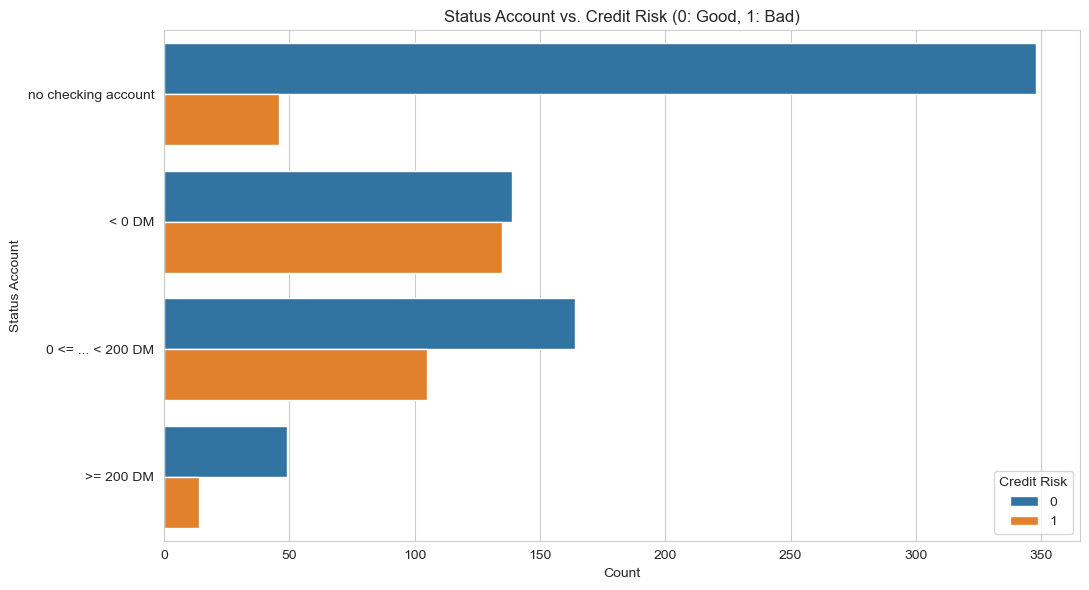

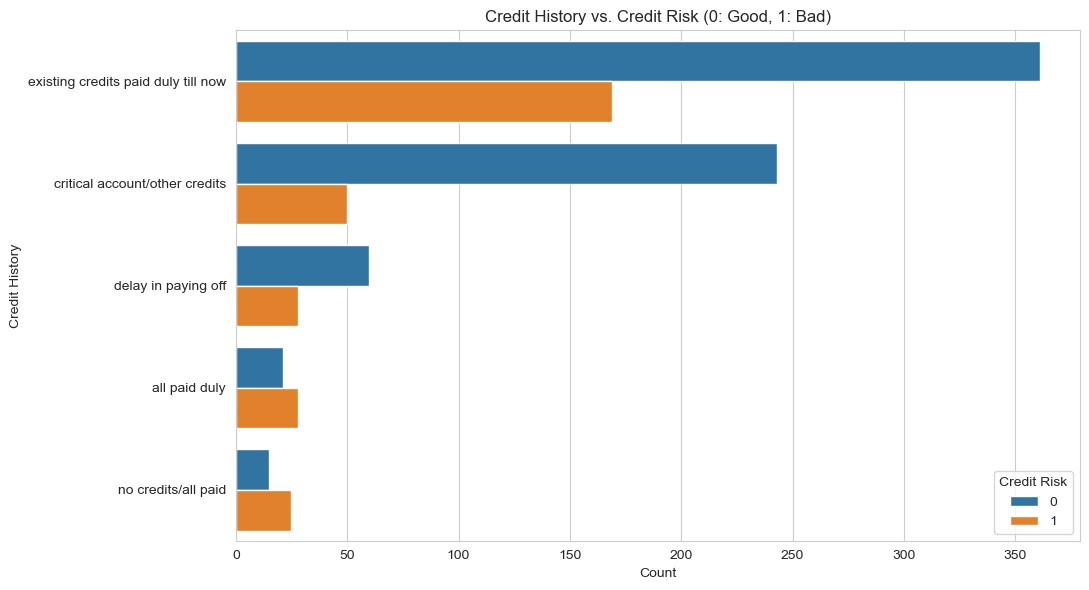

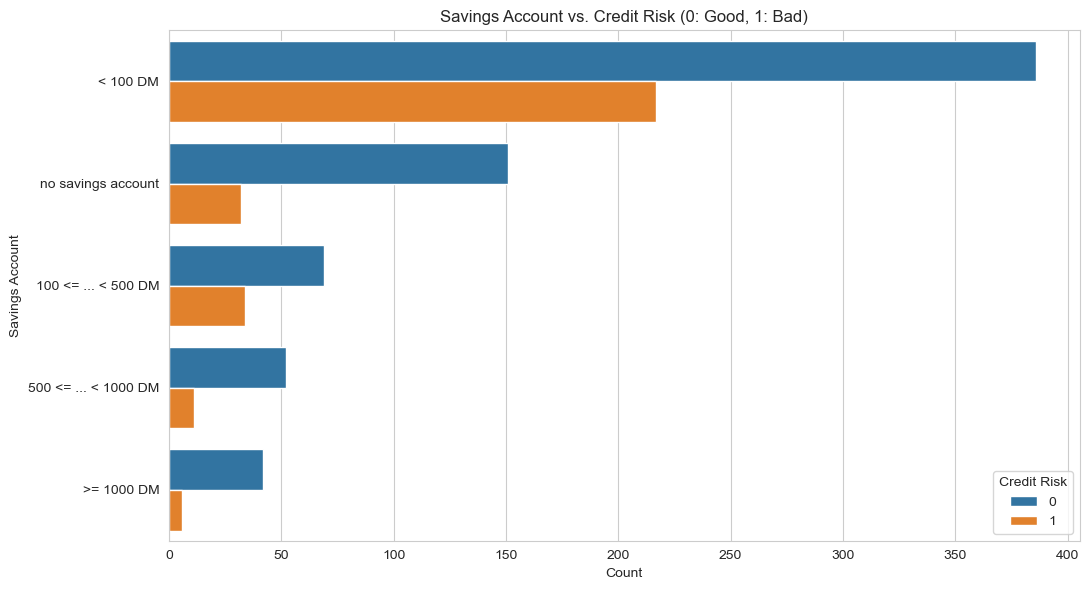

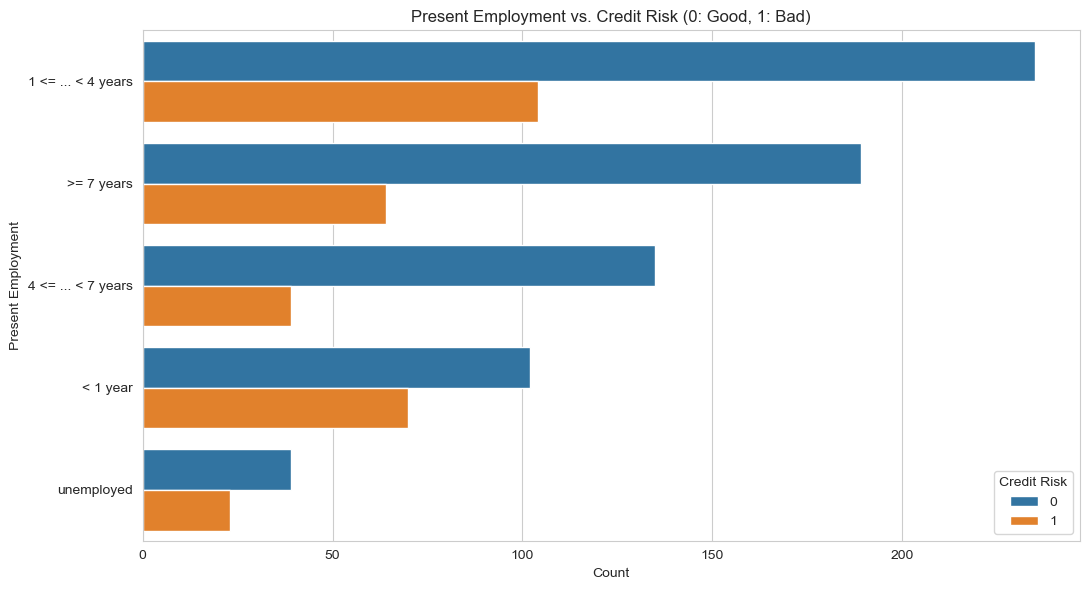

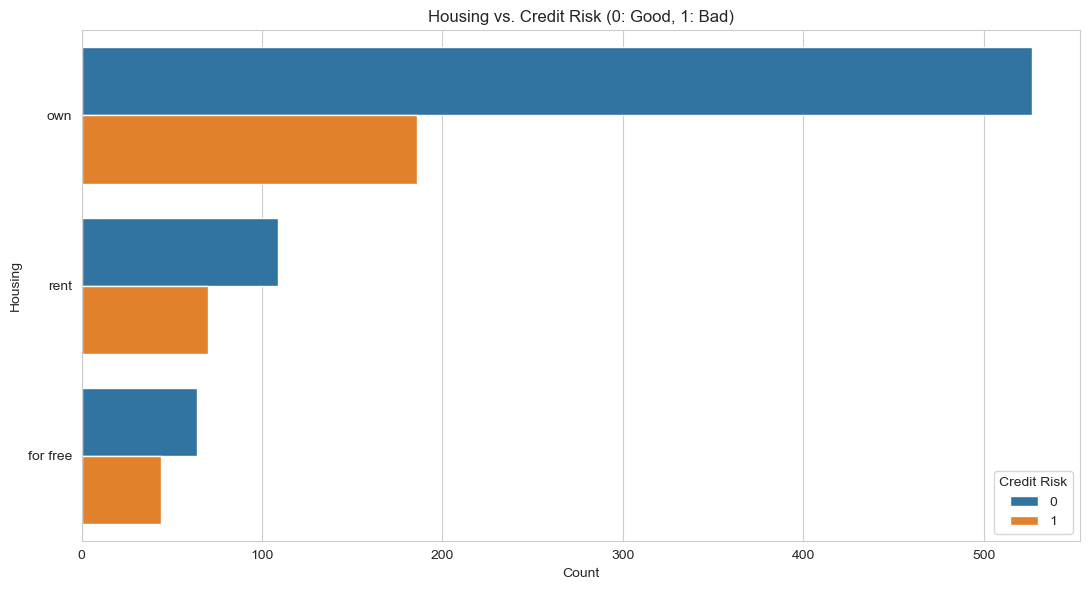

In [86]:
key_categoricals_for_target = ['status_account', 'credit_history', 'savings_account', 'present_employment', 'housing']

for feature in key_categoricals_for_target:
    plt.figure(figsize=(11, 6))
    sns.countplot(y=feature, hue='credit_risk', data=df_eda, order=df_eda[feature].value_counts().index)
    plt.title(f'{feature.replace("_", " ").title()} vs. Credit Risk (0: Good, 1: Bad)')
    plt.xlabel('Count')
    plt.ylabel(feature.replace("_", " ").title())
    plt.legend(title='Credit Risk')
    plt.tight_layout()
    plt.show()

WoE or OHE

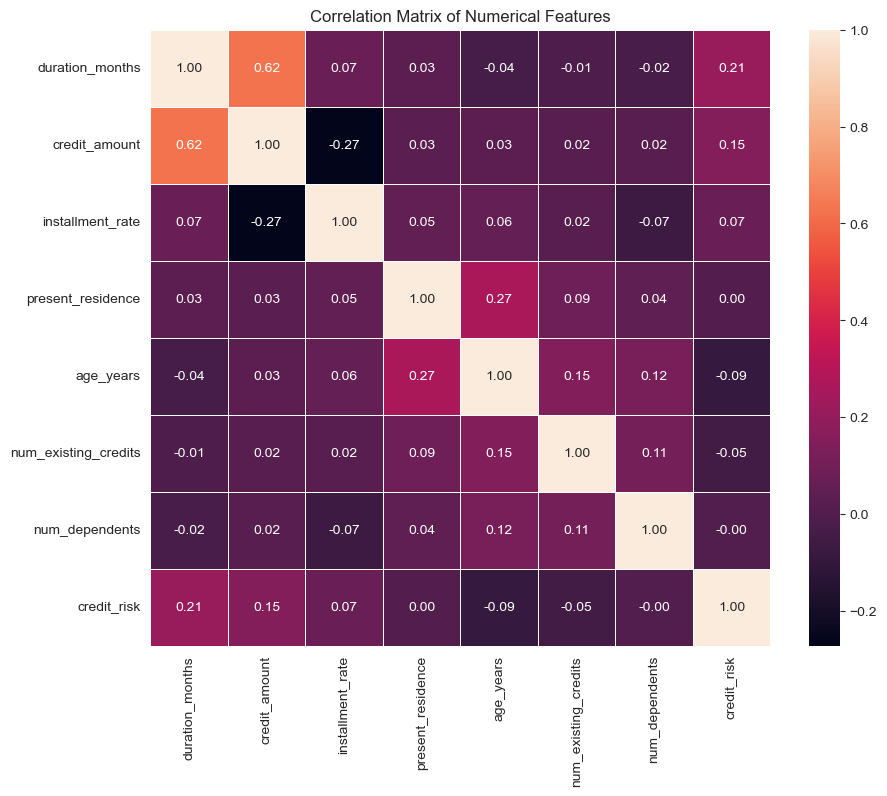

In [87]:
plt.figure(figsize=(10, 8))
corr = df_eda[numerical_features].corr()
sns.heatmap(corr, annot=True, cmap='rocket', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

- duration_month and credit_amount have the highest correlation
- longer duration loans/longer amounts -> riskier
- higher installment rate -> less riskier

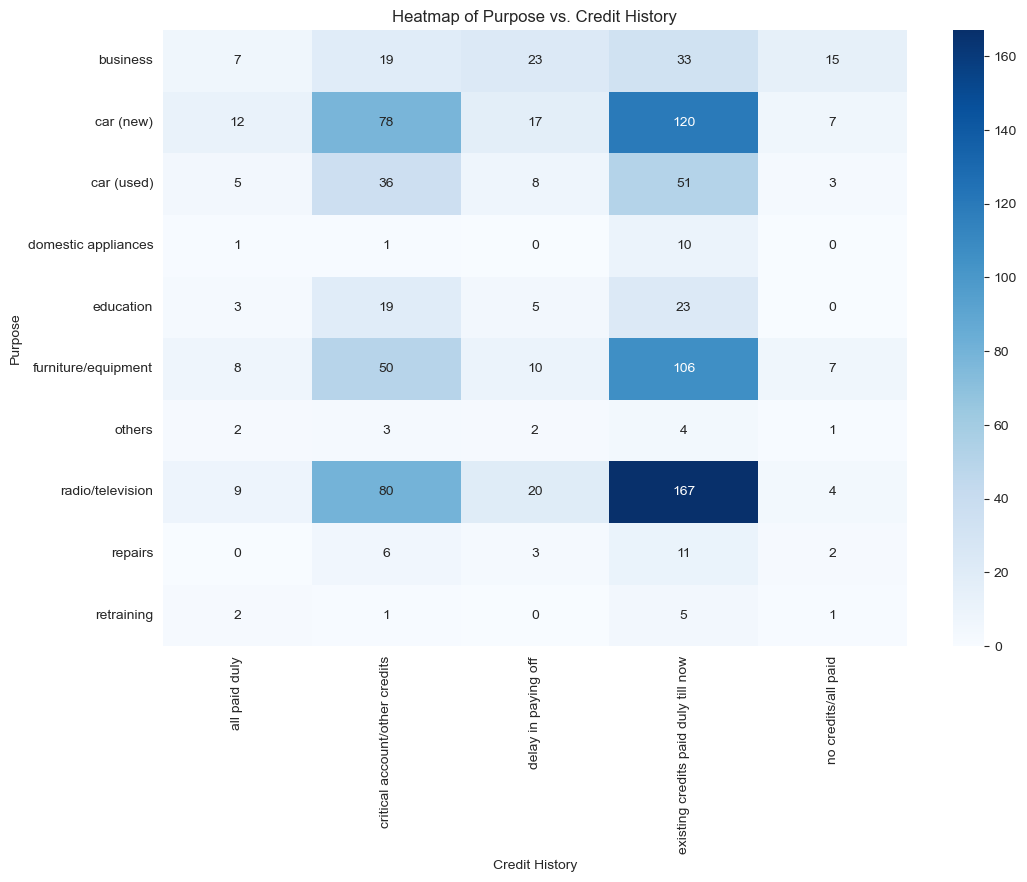

In [88]:
purpose_history_ct = pd.crosstab(df_eda['purpose'], df_eda['credit_history'])
plt.figure(figsize=(12, 8))
sns.heatmap(purpose_history_ct, annot=True, fmt="d", cmap="Blues") 
plt.title('Heatmap of Purpose vs. Credit History')
plt.xlabel('Credit History')
plt.ylabel('Purpose')
plt.show()

In [89]:
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    contingency_table = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    phi2 = chi2 / n
    r, k = contingency_table.shape
    return np.sqrt(phi2 / min(r - 1, k - 1))

# Calculate Cramér's V for categorical features
cramers_v_df = pd.DataFrame(index=categorical_features, columns=["Cramér's V"])
for col in categorical_features:
    cramers_v_df.loc[col, "Cramér's V"] = cramers_v(df_eda[col], df_eda['credit_risk'])

cramers_v_df = cramers_v_df.sort_values(by="Cramér's V", ascending=False)
print(cramers_v_df)

                        Cramér's V
status_account             0.35174
credit_history            0.248378
savings_account           0.189997
purpose                   0.182637
property                  0.154012
present_employment         0.13553
housing                   0.134907
other_installment_plans    0.11331
personal_status_sex       0.098006
other_debtors             0.081519
foreign_worker            0.076299
job                       0.043418
telephone                 0.034243


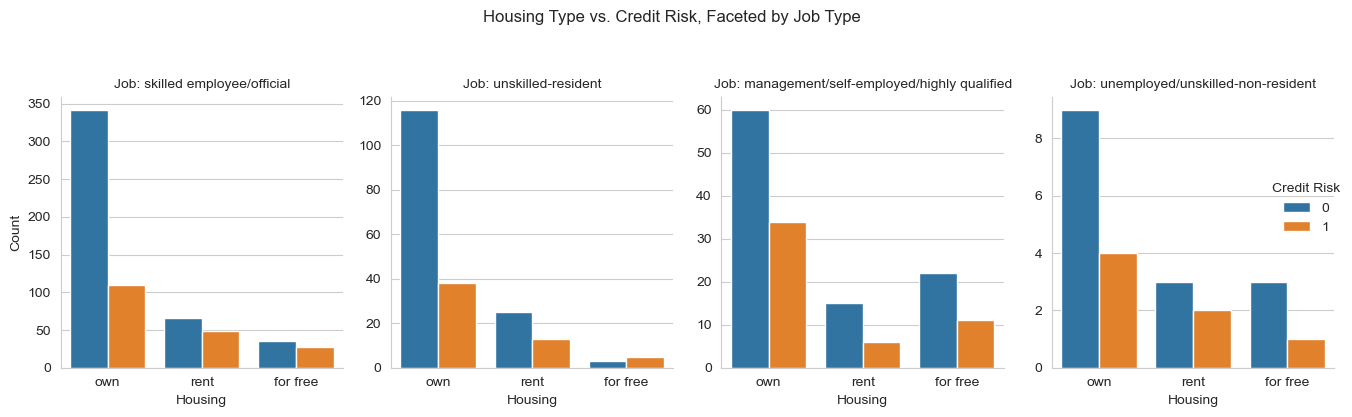

In [90]:
g = sns.catplot(x="housing", hue='credit_risk', col="job",
                data=df_eda, kind="count",
                height=4, aspect=0.8, 
                order=df_eda['housing'].value_counts().index,
                col_order=df_eda['job'].value_counts().index,
                sharey=False) 
g.fig.suptitle('Housing Type vs. Credit Risk, Faceted by Job Type', y=1.03)
g.set_axis_labels("Housing", "Count")
g.set_titles("Job: {col_name}") # Set titles for each facet
g.legend.set_title("Credit Risk")
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

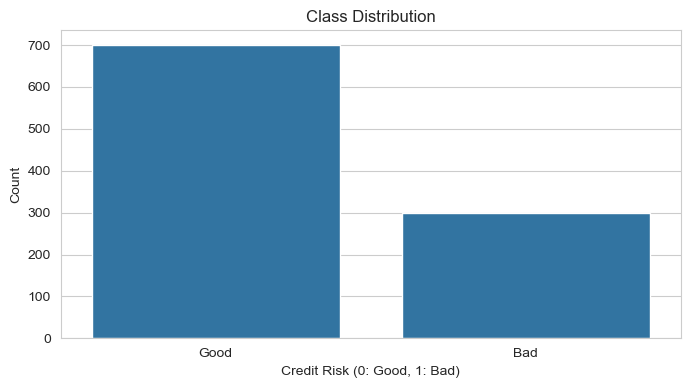

In [91]:
#Plot class distribution
plt.figure(figsize=(8, 4))
sns.countplot(x='credit_risk', data=df_eda)
plt.title('Class Distribution')
plt.xlabel('Credit Risk (0: Good, 1: Bad)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Good', 'Bad'])
plt.show()

Imbalanced data

## Preprocessing

In [251]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, MinMaxScaler, KBinsDiscretizer # Added KBinsDiscretizer
from sklearn.compose import ColumnTransformer

In [250]:
numerical_features = df.select_dtypes(include=np.number).drop(columns=[TARGET_VAR]).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist() 
numerical_features_scaled = [col for col in numerical_features if col != 'credit_amount']

In [252]:
numeric_transformer_std = Pipeline(steps=[
    ('scaler', StandardScaler()) 
])
numeric_transformer_minmax = Pipeline(steps=[
    ('scaler', MinMaxScaler()) # Use MinMaxScaler
])
log_transformer = FunctionTransformer(np.log1p, validate=True)


credit_amount_transformer = Pipeline(steps=[
    ('log', log_transformer),
    # Bin into 3 quantiles ('Low', 'Medium', 'High') represented ordinally first
    ('bin', KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile', subsample=None)),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False))
])
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False))
])

# Create the ColumnTransformer
preprocessor_std = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_std, numerical_features_scaled),
        ('cat', categorical_transformer, categorical_features),
        ('credit_log_bin', credit_amount_transformer, ['credit_amount'])
    ],
    remainder='passthrough',
    sparse_threshold=0
)

preprocessor_minmax = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_minmax, numerical_features),
        ('cat', categorical_transformer, categorical_features),
        ('credit_log_bin', credit_amount_transformer, ['credit_amount'])
    ],
    remainder='passthrough',
    sparse_threshold=0
)

preprocessor_cat_only = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), categorical_features),
        ('credit_log_bin', credit_amount_transformer, ['credit_amount'])
    ],
    remainder='passthrough', # Keep numerical features as they are
    sparse_threshold=0
)

In [254]:
TEST_SIZE = 0.3
RANDOM_STATE = 42
NUM_FOLDS = 5 
TARGET_VAR = 'credit_risk'
COST_FP = 1
COST_FN = 5

In [255]:
def cost_function(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1]) #0 (Good), 1 (Bad)
    tn, fp, fn, tp = cm.ravel()
    cost = (fp * COST_FP) + (fn * COST_FN)
    return cost


cost_scorer = make_scorer(cost_function, greater_is_better=False)

In [256]:
X = df.drop(columns=[TARGET_VAR])
y = df[TARGET_VAR]
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

In [257]:
print("Original Training target distribution:")
print(y_train.value_counts(normalize=True))
print("Testing target distribution:")
print(y_test.value_counts(normalize=True))
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Original Training target distribution:
0    0.7
1    0.3
Name: credit_risk, dtype: float64
Testing target distribution:
0    0.7
1    0.3
Name: credit_risk, dtype: float64
Training set shape: (700, 20) (700,)
Testing set shape: (300, 20) (300,)


# Model training

In [258]:
# Function for evaluation reports
def get_eval(clf, X, y):
    # Cross Validation
    ac = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
    pre = cross_val_score(clf, X, y, cv=10, scoring='precision')
    roc = cross_val_score(clf, X, y, cv=10, scoring='roc_auc')
    print("Cross Validation Accuracy: %.2f (+/- %.2f)" % (ac.mean(), ac.std()))
    print("Cross Validation Precision: %.2f (+/- %.2f)" % (pre.mean(), pre.std()))
    print("Cross Validation roc_auc: %.2f (+/- %.2f)" % (roc.mean(), roc.std()))


In [259]:
scoring = "roc_auc"

In [260]:
cv_strategy_spot = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=RANDOM_STATE)

In [261]:
models_to_check = {
    "LR": LogisticRegression(),
    "KNN": KNeighborsClassifier(),
    "DecisionTree": DecisionTreeClassifier(),
    "LDA": LinearDiscriminantAnalysis(),
    "GaussianNB": GaussianNB(),
    "GB": GradientBoostingClassifier(),
    "SVC": SVC()
}

In [262]:
# SMOTE only
results = {}
for name, model in models_to_check.items():
    #with smote
    pipeline = ImbPipeline(steps=[
        ('preprocessing', preprocessor_minmax),
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('classifier', model)
    ])

    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv_strategy_spot, scoring=scoring, n_jobs=-1)
    results[name] = cv_scores 
    mean_cost = cv_scores.mean()
    std_cost = cv_scores.std()
    print(f"{name}: Mean Cost = {mean_cost:.4f} ({std_cost:.4f})")


LR: Mean Cost = 0.7584 (0.0257)
KNN: Mean Cost = 0.6921 (0.0517)
DecisionTree: Mean Cost = 0.5990 (0.0474)
LDA: Mean Cost = 0.7500 (0.0167)
GaussianNB: Mean Cost = 0.7007 (0.0451)
GB: Mean Cost = 0.7472 (0.0369)
SVC: Mean Cost = 0.7613 (0.0410)


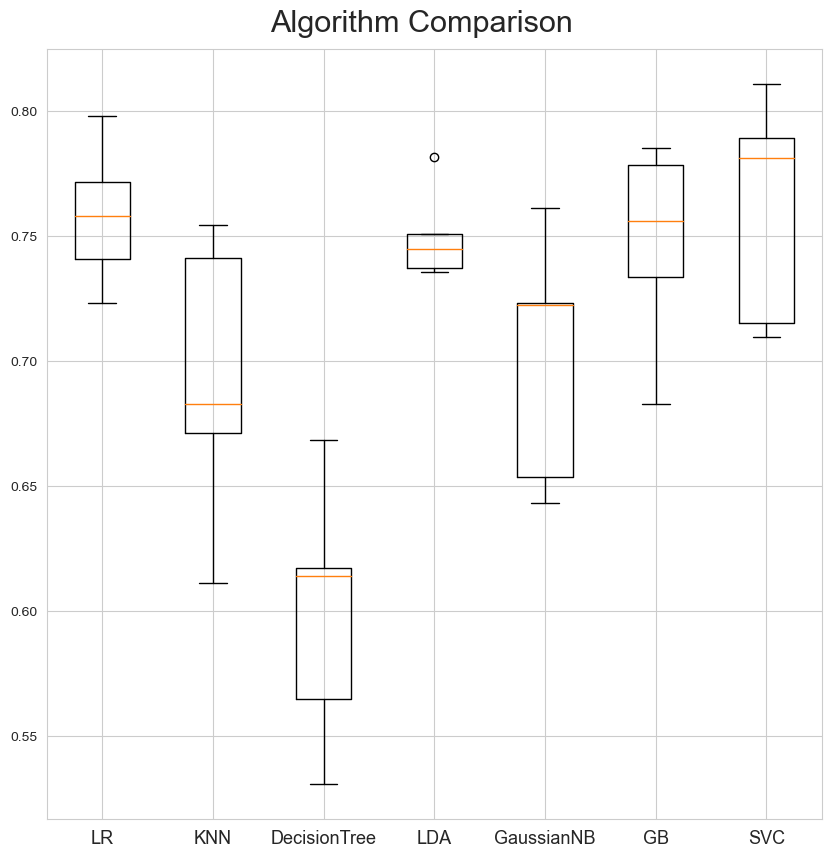

In [263]:
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Algorithm Comparison',fontsize=22, y=0.92)
ax = fig.add_subplot(111)
plt.boxplot(results.values(), labels=results.keys())
ax.set_xticklabels(results.keys(),fontsize=13)
plt.show()

In [264]:
models_to_check_2 = {
    'AB': AdaBoostClassifier(),
    'RF': RandomForestClassifier(),
    'XGB': XGBClassifier(),
    'ET': ExtraTreesClassifier()
}
results = {}
for name, model in models_to_check_2.items():
    #with smote
    pipeline = ImbPipeline(steps=[
        ('preprocessing', preprocessor_minmax),
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('classifier', model)
    ])

    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv_strategy_spot, scoring=scoring, n_jobs=-1)
    results[name] = cv_scores 
    mean_cost = cv_scores.mean()
    std_cost = cv_scores.std()
    print(f"{name}: Mean Cost = {mean_cost:.4f} ({std_cost:.4f})")


AB: Mean Cost = 0.7536 (0.0428)
RF: Mean Cost = 0.7649 (0.0370)
XGB: Mean Cost = 0.7445 (0.0364)
ET: Mean Cost = 0.7441 (0.0492)


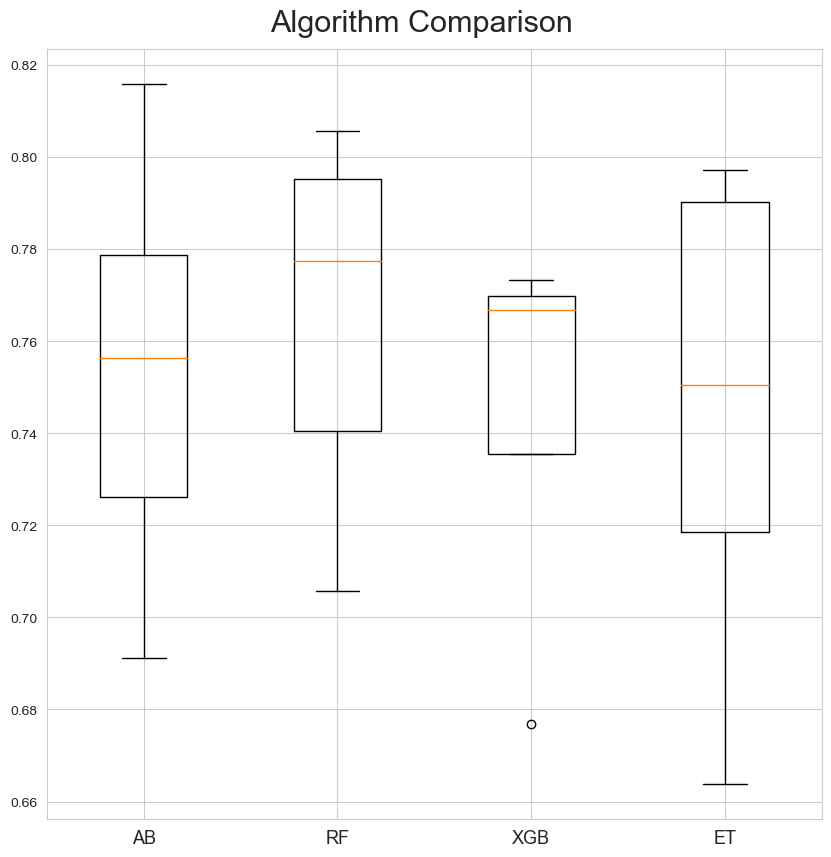

In [265]:
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Algorithm Comparison',fontsize=22, y=0.92)
ax = fig.add_subplot(111)
plt.boxplot(results.values(), labels=results.keys())
ax.set_xticklabels(results.keys(),fontsize=13)
plt.show()

## Tuning

In [266]:
# Function for evaluation reports
def get_eval(clf, X, y):
    # Cross Validation
    ac = cross_val_score(clf, X, y, cv=cv_strategy_spot, scoring='accuracy')
    pre = cross_val_score(clf, X, y, cv=cv_strategy_spot, scoring='precision')
    roc = cross_val_score(clf, X, y, cv=cv_strategy_spot, scoring='roc_auc')
    print("Cross Validation Accuracy: %.4f (+/- %.4f)" % (ac.mean(), ac.std()))
    print("Cross Validation Precision: %.4f (+/- %.4f)" % (pre.mean(), pre.std()))
    print("Cross Validation roc_auc: %.4f (+/- %.4f)" % (roc.mean(), roc.std()))


In [267]:
models_to_tune = {
    "LogisticRegression": LogisticRegression(),
    "RandomForest": RandomForestClassifier(),
    "GradientBoost": GradientBoostingClassifier(),
    "SVC": SVC(),
    "AB": AdaBoostClassifier(),
}

In [268]:
# pca
for name, model in models_to_tune.items(): 
    pipeline = ImbPipeline(steps=[
        ('preprocessing', preprocessor_std),
        ('pca', PCA(n_components=20)), 
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('classifier', model)
    ])
    print(f"Model: {name}")
    get_eval(pipeline, X_train, y_train)
    print("\n\n")

    

Model: LogisticRegression
Cross Validation Accuracy: 0.6986 (+/- 0.0245)
Cross Validation Precision: 0.4992 (+/- 0.0356)
Cross Validation roc_auc: 0.7555 (+/- 0.0261)



Model: RandomForest
Cross Validation Accuracy: 0.6814 (+/- 0.0254)
Cross Validation Precision: 0.5110 (+/- 0.0646)
Cross Validation roc_auc: 0.7331 (+/- 0.0345)



Model: GradientBoost
Cross Validation Accuracy: 0.6771 (+/- 0.0365)
Cross Validation Precision: 0.4676 (+/- 0.0485)
Cross Validation roc_auc: 0.7175 (+/- 0.0356)



Model: SVC
Cross Validation Accuracy: 0.6814 (+/- 0.0258)
Cross Validation Precision: 0.4776 (+/- 0.0315)
Cross Validation roc_auc: 0.7217 (+/- 0.0304)



Model: AB
Cross Validation Accuracy: 0.6571 (+/- 0.0310)
Cross Validation Precision: 0.4496 (+/- 0.0550)
Cross Validation roc_auc: 0.6897 (+/- 0.0388)





Pca not good

In [269]:
# SlecktKBest
for name, model in models_to_tune.items():
    pipeline = ImbPipeline(steps=[
        ('preprocessing', preprocessor_minmax),
        ('feature_selection', SelectKBest(score_func=chi2, k=30)), 
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('classifier', model)
    ])
    print(f"Model: {name}")
    get_eval(pipeline, X_train, y_train)
    print("\n\n")

Model: LogisticRegression
Cross Validation Accuracy: 0.6957 (+/- 0.0229)
Cross Validation Precision: 0.4953 (+/- 0.0251)
Cross Validation roc_auc: 0.7586 (+/- 0.0344)



Model: RandomForest
Cross Validation Accuracy: 0.7300 (+/- 0.0371)
Cross Validation Precision: 0.5538 (+/- 0.0557)
Cross Validation roc_auc: 0.7519 (+/- 0.0493)



Model: GradientBoost
Cross Validation Accuracy: 0.7243 (+/- 0.0262)
Cross Validation Precision: 0.5394 (+/- 0.0419)
Cross Validation roc_auc: 0.7568 (+/- 0.0374)



Model: SVC
Cross Validation Accuracy: 0.7057 (+/- 0.0159)
Cross Validation Precision: 0.5078 (+/- 0.0199)
Cross Validation roc_auc: 0.7529 (+/- 0.0483)



Model: AB
Cross Validation Accuracy: 0.7200 (+/- 0.0194)
Cross Validation Precision: 0.5312 (+/- 0.0290)
Cross Validation roc_auc: 0.7576 (+/- 0.0259)





for SKbest only model AB seems a little better

In [270]:
from sklearn.feature_selection import RFE

In [271]:
# Recursive feature elimination (RFE)
pipeline_rfe_lr = ImbPipeline(steps=[
    ('preprocessing', preprocessor_cat_only),
    ('feature_selection', RFE(LogisticRegression(), n_features_to_select=50)), 
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('classifier',LogisticRegression())
])
get_eval(pipeline_rfe_lr, X_train, y_train)

Cross Validation Accuracy: 0.6914 (+/- 0.0223)
Cross Validation Precision: 0.4918 (+/- 0.0249)
Cross Validation roc_auc: 0.7535 (+/- 0.0177)


not good too...

=> The best pipeline is just preprocessing (minmax,onehot) then SMOTE

In [272]:
models_to_tune = {
    "LogisticRegression": LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', max_iter=2000),
    "RandomForest": RandomForestClassifier(random_state=RANDOM_STATE),
    "GradientBoost": GradientBoostingClassifier(random_state=RANDOM_STATE),
    "SVC": SVC(random_state=RANDOM_STATE),
    "AB": AdaBoostClassifier(random_state=RANDOM_STATE),
}

In [273]:
param_grids = {
    "LogisticRegression": {
        'smote__k_neighbors': [5, 10, 50, 100], 
        'classifier__C': [0.01, 0.1, 1, 10, 100],
        'classifier__penalty': ['l1']
    },
    "GradientBoost": {
        'smote__k_neighbors': [5, 10, 50, 100], 
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_depth': [3, 5, 7],
        'classifier__min_samples_split': [2, 5],
        'classifier__min_samples_leaf': [1, 3]
    },
    "SVC": {
        'smote__k_neighbors': [5, 10, 50, 100], 
        'classifier__C': [0.01, 0.1, 1, 10, 100],
        'classifier__kernel': ['linear', 'rbf'],
        'classifier__gamma': ['scale', 'auto']
    },
    "RandomForest": {
        'smote__k_neighbors': [5, 50, 100], 
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5],
        'classifier__min_samples_leaf': [1, 3]
    },
    "AB": {
        'smote__k_neighbors': [5, 10, 50, 100], 
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__algorithm': ['SAMME', 'SAMME.R']
    }
}

best_estimators = {}
best_scores = {}

In [274]:
cv_strategy_tune = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=RANDOM_STATE)

for name, model in models_to_tune.items():
    pipeline = ImbPipeline(steps=[
        ('preprocessing', preprocessor_minmax),
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('classifier', model)
    ])

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grids[name],
        scoring=scoring, #roc
        cv=cv_strategy_tune,
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X_train, y_train)

    best_estimators[name] = grid_search.best_estimator_
    best_scores[name] = grid_search.best_score_

    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best score for {name}: {best_scores[name]:.4f}")



Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for LogisticRegression: {'classifier__C': 1, 'classifier__penalty': 'l1', 'smote__k_neighbors': 100}
Best score for LogisticRegression: 0.7598
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters for RandomForest: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200, 'smote__k_neighbors': 50}
Best score for RandomForest: 0.7873
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best parameters for GradientBoost: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50, 'smote__k_neighbors': 50}
Best score for GradientBoost: 0.7655
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best parameters for SVC: {'classifier__C': 1, 'classifier__gamma': 'auto', 'classifier__kernel':

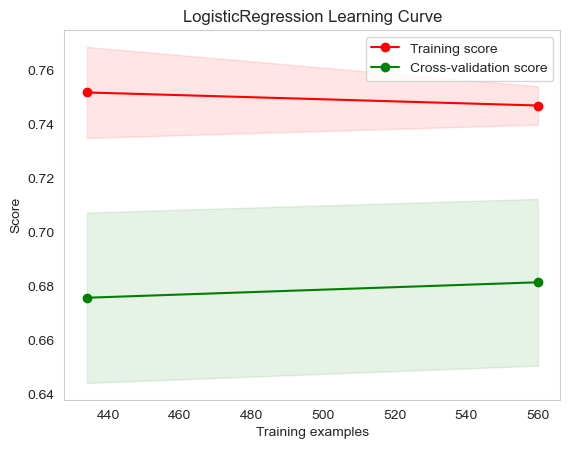

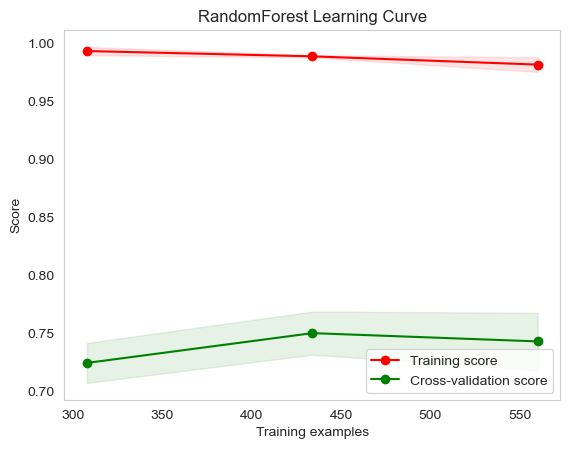

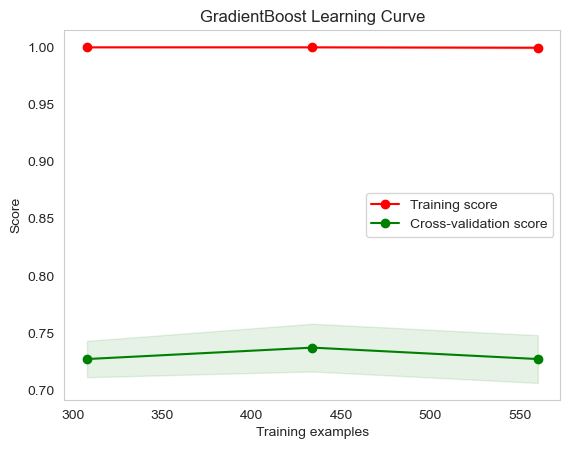

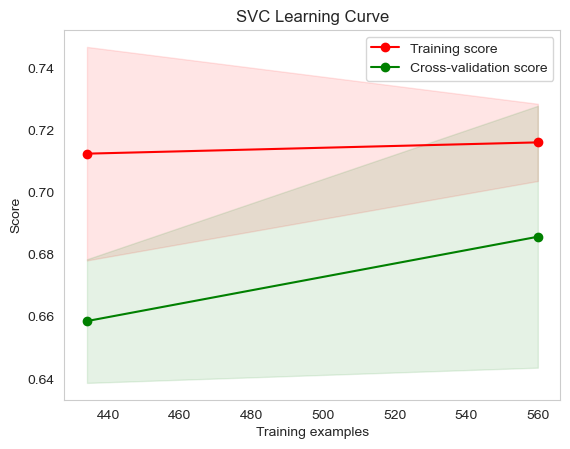

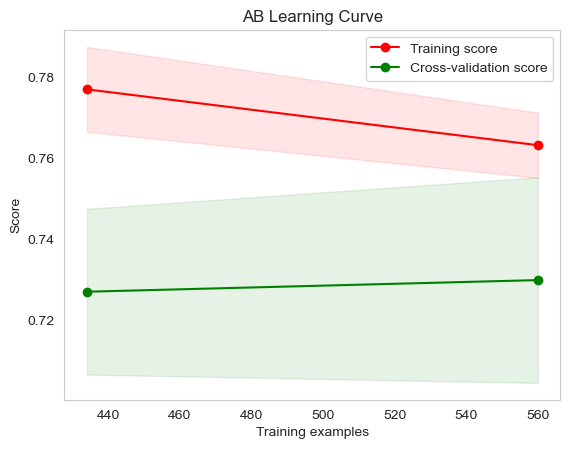

In [275]:
from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

sfolder = StratifiedKFold(n_splits=NUM_FOLDS,random_state=RANDOM_STATE,shuffle=True)
for name, estimator in best_estimators.items():
    g = plot_learning_curve(estimator,f"{name} Learning Curve",X_train,y_train,cv=sfolder)


In [276]:
print(best_estimators['LogisticRegression'])

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['duration_months',
                                                   'credit_amount',
                                                   'installment_rate',
                                                   'present_residence',
                                                   'age_years',
                                                   'num_existing_credits',
                                                   'num_dependents']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                         

In [278]:
#BChoose model
final_model_pipeline = best_estimators['LogisticRegression']

y_pred_train = final_model_pipeline.predict(X_train)
y_pred_proba_train = final_model_pipeline.predict_proba(X_train)[:, 1]
print("\nPredicting on Test Set...")
y_pred_test = final_model_pipeline.predict(X_test)
y_pred_proba_test = final_model_pipeline.predict_proba(X_test)[:, 1]


Predicting on Test Set...


# Evaluation

In [279]:
train_accuracy = accuracy_score(y_train, y_pred_train)
train_auc = roc_auc_score(y_train, y_pred_proba_train)
train_gini = 2 * train_auc - 1

print(" In-Sample Performance (Training Set)")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"AUC:      {train_auc:.4f}")
print(f"Gini:     {train_gini:.4f}")

 In-Sample Performance (Training Set)
Accuracy: 0.7543
AUC:      0.8283
Gini:     0.6567


### Out-of-sample eval

In [280]:
final_cost = cost_function(y_test, y_pred_test)
final_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Test Set Cost: {final_cost}")
print(f"Test Set Accuracy: {final_accuracy:.4f}")

Test Set Cost: 171
Test Set Accuracy: 0.7367



Confusion Matrix (Test Set):


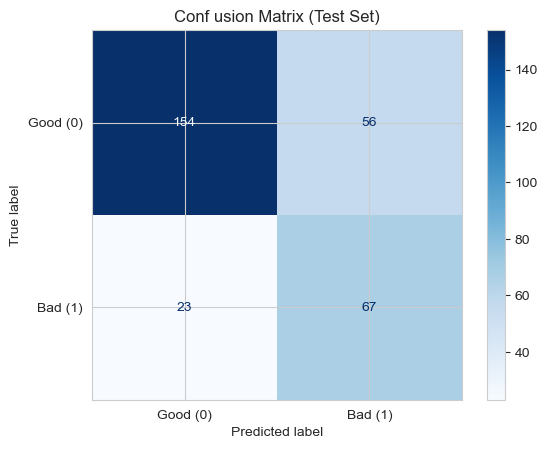

In [281]:
print("\nConfusion Matrix (Test Set):")
cm_test = confusion_matrix(y_test, y_pred_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Good (0)', 'Bad (1)'])
disp_test.plot(cmap='Blues') # Or another colormap
plt.title('Conf usion Matrix (Test Set)')
plt.show()

In [282]:
tn, fp, fn, tp = cm_test.ravel()
print(f"True Negatives (TN): {tn} (Correctly predicted Good)")
print(f"False Positives (FP): {fp} (Incorrectly predicted Bad - Cost 1)")
print(f"False Negatives (FN): {fn} (Incorrectly predicted Good - Cost 5!)")
print(f"True Positives (TP): {tp} (Correctly predicted Bad)")

True Negatives (TN): 154 (Correctly predicted Good)
False Positives (FP): 56 (Incorrectly predicted Bad - Cost 1)
False Negatives (FN): 23 (Incorrectly predicted Good - Cost 5!)
True Positives (TP): 67 (Correctly predicted Bad)



Classification Report (Test Set):


<Axes: >

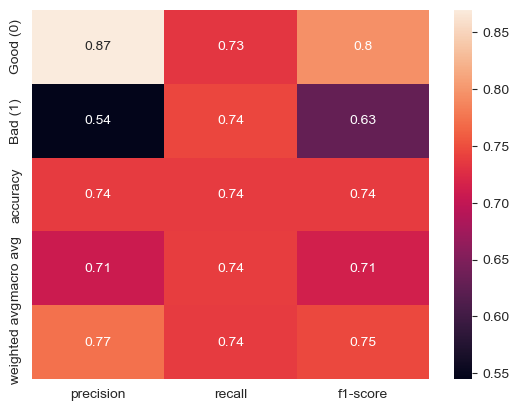

In [283]:
print("\nClassification Report (Test Set):")

report_test = classification_report(y_test, y_pred_test, target_names=['Good (0)', 'Bad (1)'], output_dict=True) 
sns.heatmap(pd.DataFrame(report_test).iloc[:-1, :].T, annot=True)

In [284]:
test_accuracy = report_test['accuracy']
recall_bad_test = report_test['Bad (1)']['recall']
recall_good_test = report_test['Good (0)']['recall'] 
precision_bad_test = report_test['Bad (1)']['precision']
f1_bad_test = report_test['Bad (1)']['f1-score']

print(f"\nRecall for Bad Risk (Class 1): {recall_bad_test:.4f}") 
#Proportion of actual Bad applicants correctly identified


Recall for Bad Risk (Class 1): 0.7444



Test AUC: 0.8017
Test Gini: 0.6035


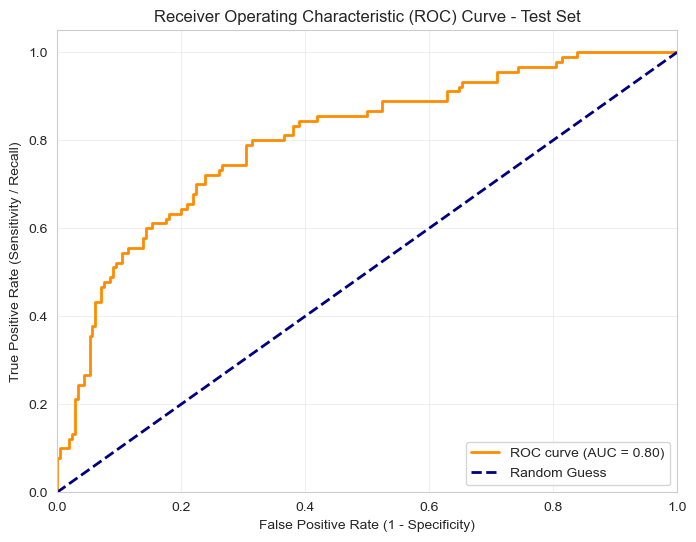

In [285]:
test_auc = roc_auc_score(y_test, y_pred_proba_test)
test_gini = 2 * test_auc - 1
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_test)

print(f"\nTest AUC: {test_auc:.4f}")
print(f"Test Gini: {test_gini:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {test_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity / Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Set')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

## Result

In [286]:
report_train = classification_report(y_train, y_pred_train, target_names=['Good (0)', 'Bad (1)'], output_dict=True)
recall_bad_train = report_train['Bad (1)']['recall']

print("\n--- Performance Comparison ---")
print(f"Metric         | Train Set | Test Set  | Difference")
print(f"---------------|-----------|-----------|------------")
print(f"Accuracy       | {train_accuracy:.4f}    | {test_accuracy:.4f}    | {train_accuracy-test_accuracy:.4f}")
print(f"AUC            | {train_auc:.4f}    | {test_auc:.4f}    | {train_auc-test_auc:.4f}")
print(f"Gini           | {train_gini:.4f}    | {test_gini:.4f}    | {train_gini-test_gini:.4f}")
print(f"Recall (Bad=1) | {recall_bad_train:.4f}    | {recall_bad_test:.4f}    | {recall_bad_train-recall_bad_test:.4f}")



--- Performance Comparison ---
Metric         | Train Set | Test Set  | Difference
---------------|-----------|-----------|------------
Accuracy       | 0.7543    | 0.7367    | 0.0176
AUC            | 0.8283    | 0.8017    | 0.0266
Gini           | 0.6567    | 0.6035    | 0.0532
Recall (Bad=1) | 0.7762    | 0.7444    | 0.0317


In [287]:
#Calculate differences
diff_accuracy = train_accuracy - test_accuracy
diff_auc = train_auc - test_auc
diff_gini = train_gini - test_gini
diff_recall_bad = recall_bad_train - recall_bad_test

data_for_df = {
    'Metric': ['Accuracy', 'AUC', 'Gini', 'Recall (Bad=1)'],
    'Train Set': [train_accuracy, train_auc, train_gini, recall_bad_train],
    'Test Set': [test_accuracy, test_auc, test_gini, recall_bad_test],
    'Difference': [diff_accuracy, diff_auc, diff_gini, diff_recall_bad]
}
performance_df = pd.DataFrame(data_for_df)

print("\nPerformance Summary DataFrame:")
print(performance_df.round(4)) # Display with 4 decimal places

# Save DataFrame to CSV
csv_filename = 'LR_model_performanc_1.csv'
performance_df.to_csv(csv_filename, index=False, float_format='%.4f')


Performance Summary DataFrame:
           Metric  Train Set  Test Set  Difference
0        Accuracy     0.7543    0.7367      0.0176
1             AUC     0.8283    0.8017      0.0266
2            Gini     0.6567    0.6035      0.0532
3  Recall (Bad=1)     0.7762    0.7444      0.0317
